***This notebook is developed by Prof. Monali Mavani***

This notebook demonstates transfer learning using VGG16 model on image dataset - CIFAR10

Dataset: https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html

Model: https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html

Reference : https://pytorch.org/

Load a pretrained model and modify it for transfer learning.
    
    
    1. Loading a pretrained model (trained on ImageNet)
    2. Freezing the feature extraction layers (backbone)
    3. Replacing the final classifier for the target dataset

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import datetime
import os
from torchvision import transforms, datasets, models

In [ ]:
# Step 1: Initialize Parameters and Hyperparameters
# Hyperparameters
input_size = 32 * 32 * 3  # CIFAR10 images are 32 * 32 *3

num_classes = 10      # CIFAR10 has 10 classes
learning_rate = 0.001
batch_size = 64
num_epochs = 5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Transforms** are common image transformations. They can be chained together using Compose

All transformations accept PIL Image, Tensor Image or batch of Tensor Images as input. Tensor Image is a tensor with (C, H, W) shape, where C is a number of channels, H and W are image height and width. Batch of Tensor Images is a tensor of (B, C, H, W) shape, where B is a number of images in the batch.

**transforms.toTensor()** Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

**transforms.Normalize((0.5,), (0.5,)** :  
normalizes the data of [0,1] into [-1,1] scale by performing (input-0.5)/0.5, so [0,1]->[-1,1]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

### Understanding torchvision datasets

In [ ]:
# CIFAR 10 dataset

train_dataset1 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=None, download=True)
test_dataset1 = torchvision.datasets.CIFAR10(root='./data', train=False, transform=None)

len(train_dataset1)

50000

In [ ]:
len(test_dataset1)

10000

In [ ]:
#first element is a PIL image and the second is an target
train_dataset1[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [ ]:
train_image_zero, train_target_zero = train_dataset1[0]
train_image_zero
print(train_image_zero.size)


(32, 32)


In [ ]:
print(train_image_zero.size)
print(train_target_zero)

(32, 32)
6


### loading dataset using data loader

In [ ]:
# Step 2: Load CIFAR dataset and perform image pre processing
# MNIST dataset (32x32X3images of digits 0-9)

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)


In [ ]:
train_dataset[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

DataLoader()
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API. PyTorch Dataloader is a utility class designed to simplify loading and iterating over datasets while training deep learning models. It has various constraints to iterating datasets, like batching, shuffling, and processing data

In [ ]:
# DataLoader returns the batched data (input features and labels) to the training loop.
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#iterating over dataloader, each batch size is 10000
i=0
for X_batch, y_batch in train_loader:
    #print(X_batch, y_batch)
    print(X_batch.shape, y_batch.shape)
    i=i+1
    if i==1:
      break


torch.Size([64, 3, 32, 32]) torch.Size([64])


### Define the Neural Network using torch.nn.Module
Base class for all neural network modules. Your models should also subclass this class.

An nn.Module contains layers, and a method forward(input) that returns the output.

https://pytorch.org/docs/stable/nn.html


In [ ]:
def get_pretrained_model(model_name):

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False

# === CLASSIFIER MODIFICATION ===
        # Get the number of input features to the final classifier layer
        # VGG16 architecture: features -> avgpool -> classifier
        # classifier[6] is the final FC layer: Linear(4096 -> 1000) for ImageNet

        n_inputs = model.classifier[6].in_features
        print( "VGG 16 final conv layer output size",n_inputs)
        # Add on classifier
#In VGG16, the final classifier layer (commonly referred to as classifier[6]) is a fully-connected (FC) layer responsible for mapping
#features extracted by the network to class predictions, changing the original 1000-class output layer (from ImageNet) into a smaller
 #(or differently sized) classifier layer for your dataset with num_classes
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes), nn.LogSoftmax(dim=1))
    return model

In [ ]:
from torchsummary import summary
model = get_pretrained_model('vgg16')
model.to(device)
summary(model, input_size=(3, 32, 32), batch_size=batch_size, device='cuda')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 135MB/s]


4096
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 32, 32]           1,792
              ReLU-2           [64, 64, 32, 32]               0
            Conv2d-3           [64, 64, 32, 32]          36,928
              ReLU-4           [64, 64, 32, 32]               0
         MaxPool2d-5           [64, 64, 16, 16]               0
            Conv2d-6          [64, 128, 16, 16]          73,856
              ReLU-7          [64, 128, 16, 16]               0
            Conv2d-8          [64, 128, 16, 16]         147,584
              ReLU-9          [64, 128, 16, 16]               0
        MaxPool2d-10            [64, 128, 8, 8]               0
           Conv2d-11            [64, 256, 8, 8]         295,168
             ReLU-12            [64, 256, 8, 8]               0
           Conv2d-13            [64, 256, 8, 8]         590,080
             ReLU-14            [6

In [ ]:
print(model.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)


In [ ]:
model.class_to_idx = train_dataset.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'airplane'),
 (1, 'automobile'),
 (2, 'bird'),
 (3, 'cat'),
 (4, 'deer'),
 (5, 'dog'),
 (6, 'frog'),
 (7, 'horse'),
 (8, 'ship'),
 (9, 'truck')]

In [ ]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    model = model.to('cuda')

In [ ]:
#Returns the total number of elements in the input tensor.
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable model parameters:", num_params)

Total number of trainable model parameters: 1051402


In [ ]:
# Step 4: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Step 5: Train the model
start_time = time.time()

for epoch in range(num_epochs):
    print(f'Starting epoch {epoch + 1}')
    running_loss = 0.0

    model.train() # Set the model to training mode

    for i, batch in enumerate(train_loader,0):

        images, labels = batch
        images, labels = images.to(device), labels.to(device) # Move the model to the device

        # Forward propagate
        outputs = model(images) # Forward pass
        loss = criterion(outputs, labels) # Compute the loss

        # Backpropagate
        optimizer.zero_grad() # Zero the gradients
        loss.backward() # Backward pass (compute gradients)

       # Update parameters
        optimizer.step() # Update model parameters

        running_loss += loss.item()
        if i % 100 == 99:
             print(f'batch {i+1}, Loss: {running_loss/100}')
             running_loss = 0.0

   # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

end_time = time.time() # Record end time
print('Training process has been completed. ')
training_time = end_time - start_time

print('Training time:', str(datetime.timedelta(seconds=training_time))) # for calculating the training time in minutes and seconds format


Starting epoch 1
batch 100, Loss: 1.485339810848236
batch 200, Loss: 1.3010353279113769
batch 300, Loss: 1.275811059474945
batch 400, Loss: 1.282517575621605
batch 500, Loss: 1.2473729878664017
batch 600, Loss: 1.2227535676956176
batch 700, Loss: 1.2327392476797103
Starting epoch 2
batch 100, Loss: 1.1877826249599457
batch 200, Loss: 1.1785250842571258
batch 300, Loss: 1.161914011836052
batch 400, Loss: 1.189522801041603
batch 500, Loss: 1.1978879243135452
batch 600, Loss: 1.1779108756780625
batch 700, Loss: 1.180791630744934
Starting epoch 3
batch 100, Loss: 1.133305692076683
batch 200, Loss: 1.1508476078510284
batch 300, Loss: 1.146054611802101
batch 400, Loss: 1.1484496718645096
batch 500, Loss: 1.1763249325752259
batch 600, Loss: 1.14164002597332
batch 700, Loss: 1.134975568652153
Starting epoch 4
batch 100, Loss: 1.1022539538145066
batch 200, Loss: 1.1043799358606339
batch 300, Loss: 1.106764291524887
batch 400, Loss: 1.1287304383516312
batch 500, Loss: 1.1265617042779923
batch 60

In [ ]:
# Step 6: Evaluate model performance
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) #Get the predicted classes from the output logits

        total += labels.size(0) #labels:Tensor with dimensions [no of samples in the batch, 1], labels.size(0) returns no of samples in a batch
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Accuracy of the model on the test images: 62.12%


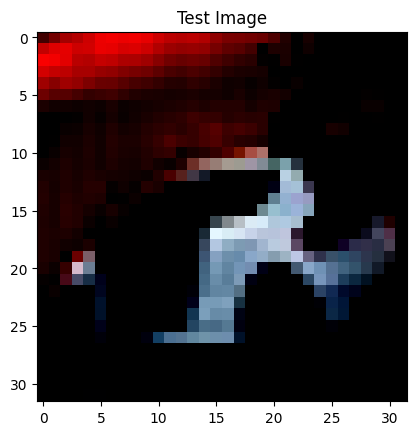

Predicted label for the first test image: 1


In [ ]:
import matplotlib.pyplot as plt

# Step 7: Use the model for inference
sample_image, _ = test_dataset[6]  # Take the sixth test sample

# Display the test image
plt.imshow(sample_image.permute(1, 2, 0))
#plt.imshow(sample_image.squeeze(), cmap='gray')  # Remove the batch dimension and display the image
plt.title('Test Image')
plt.show()

# Add batch dimension and move the image to the device
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

# Set model to evaluation mode
model.eval()

# Perform inference without tracking gradients
with torch.no_grad():
    prediction = model(sample_image)
    predicted_label = torch.argmax(prediction, 1).item()  # Get the predicted class label
    print(f'Predicted label for the first test image: {predicted_label}')
